## Test runner

### Torch import

In [18]:
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cpu.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cpu.html
# !pip install -q torch-geometric

### Import libraries

In [1]:
import os, sys
from typing import List, Tuple
from collections.abc import Callable
import time
import datetime as dt
from tqdm.notebook import tqdm

In [24]:
import pandas as pd
import numpy as np
import networkx as nx

In [3]:
from scipy.stats import wasserstein_distance

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [23]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, DenseDataLoader

from torch_geometric.nn import GraphConv, global_add_pool, DenseGraphConv, dense_diff_pool
import torch.nn.functional as F
from torch.nn import NLLLoss

from torch_geometric.utils import to_dense_adj, to_networkx
from torch_geometric.transforms import ToDense

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8.27

import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [7]:
from ipywidgets import interact, interact_manual, FloatSlider

In [8]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src/'))

from src.utils import load_dataset
from src.models import DiffPool, BaselineGNN
from src.train import train
from src.metrics import evaluate, TrainingMetrics, TestingMetrics

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

### Fetch data

In [9]:
model_args = dict(
    num_classes=2,
    hidden_dim=64,
    node_features_dim=43)

model = BaselineGNN(layer_type='GAT', **model_args)

model.reset()

In [10]:
dataset_train, dataset_test = load_dataset(dense=model.is_dense())

In [11]:
criterion = NLLLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0005, weight_decay=0.01)

device = None
dense = model.is_dense()

In [12]:
loader_train_args = dict(dataset=dataset_train[:round(len(dataset_train) * .8)], batch_size=4)
loader_valid_args = dict(dataset=dataset_train[round(len(dataset_train) * .8):], batch_size=4)
        
loader_train = DenseDataLoader(**loader_train_args) if model.is_dense() \
    else DataLoader(**loader_train_args)
loader_valid = DenseDataLoader(**loader_valid_args) if model.is_dense() \
    else DataLoader(**loader_valid_args)

In [13]:
metrics = TrainingMetrics()

In [14]:
for epoch in tqdm(range(40)):
    epoch_loss = 0.

    model.train()
    
    for data in loader_train:
        data.to(device)
        
        output = model(data)
        
        loss = criterion(output, data.y.flatten())

        optimizer.zero_grad()
        
        epoch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        
    acc_train, _ = evaluate(model, loader_train)
    acc_valid, loss_valid = evaluate(model, loader_valid, validation=True)

    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train: {acc_train:.3f}, Val: {acc_valid:.3f}, Loss: {epoch_loss:.3f}, Val. loss: {loss_valid:.3f}')
        
    with torch.no_grad():
        metrics.log_metric('Loss - training', epoch_loss, step=epoch)
        metrics.log_metric('Loss - validation', loss_valid, step=epoch)
        metrics.log_metric('Accuracy - training', acc_train, step=epoch)
        metrics.log_metric('Accuracy - validation', acc_valid, step=epoch)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 000, Train: 0.579, Val: 0.643, Loss: 10.448, Val. loss: 2.644
Epoch: 010, Train: 0.807, Val: 0.643, Loss: 8.203, Val. loss: 2.593
Epoch: 020, Train: 0.930, Val: 0.429, Loss: 2.711, Val. loss: 5.297
Epoch: 030, Train: 1.000, Val: 0.429, Loss: 0.340, Val. loss: 6.086


In [15]:
loader_test_args = dict(dataset=dataset_test, batch_size=len(dataset_test))

loader_test = DenseDataLoader(**loader_test_args) if model.is_dense() \
    else DataLoader(**loader_test_args)

test_metrics = TestingMetrics(epoch=75)
test_metrics.compute_metrics(model, loader_test)
pd.DataFrame(test_metrics.storage)

,metric,value
0,Accuracy - testing,0.777778
1,Precision - testing,0.750000
2,Recall - testing,0.500000
3,Fscore - testing,0.600000


In [17]:
# fig, ax = plt.subplots()

# test_metrics.plot_confusion_matrix(ax)

In [71]:
x, edge_index = graph.x, graph.edge_index

for step in range(len(model.convs) - 1):
    x = model.convs[step](x, edge_index)

x, (edge_index, alpha) = model.convs[-1](x, edge_index, return_attention_weights=True)

In [128]:
edge_index.size(), alpha.size()

(torch.Size([2, 53]), torch.Size([53, 1]))

In [130]:
transformed_graph = Data(x=x, edge_index=edge_index, edge_attr=alpha.flatten())
transformed_graph

Data(x=[10, 64], edge_index=[2, 53], edge_attr=[53])

In [131]:
# e_as = dict(zip(
#     map(tuple, transformed_graph.edge_index.t().tolist()), 
#     transformed_graph.edge_attr.reshape(-1).tolist()))

e_as = transformed_graph.edge_attr.reshape(-1) * 10000
e_as = e_as.tolist()
e_as = list(map(round, e_as))

In [132]:
len(G.edges()), len(e_as)

(32, 53)

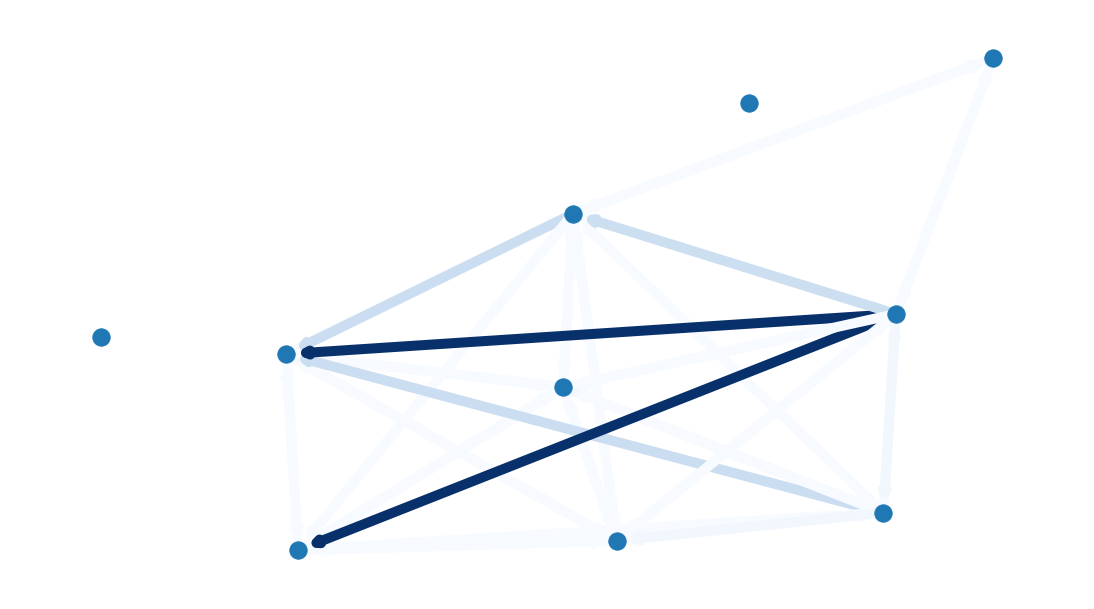

In [133]:
G = to_networkx(transformed_graph)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, edgelist=G.edges(), edge_color=e_as, width=10.0, edge_cmap=plt.cm.Blues)

plt.show()

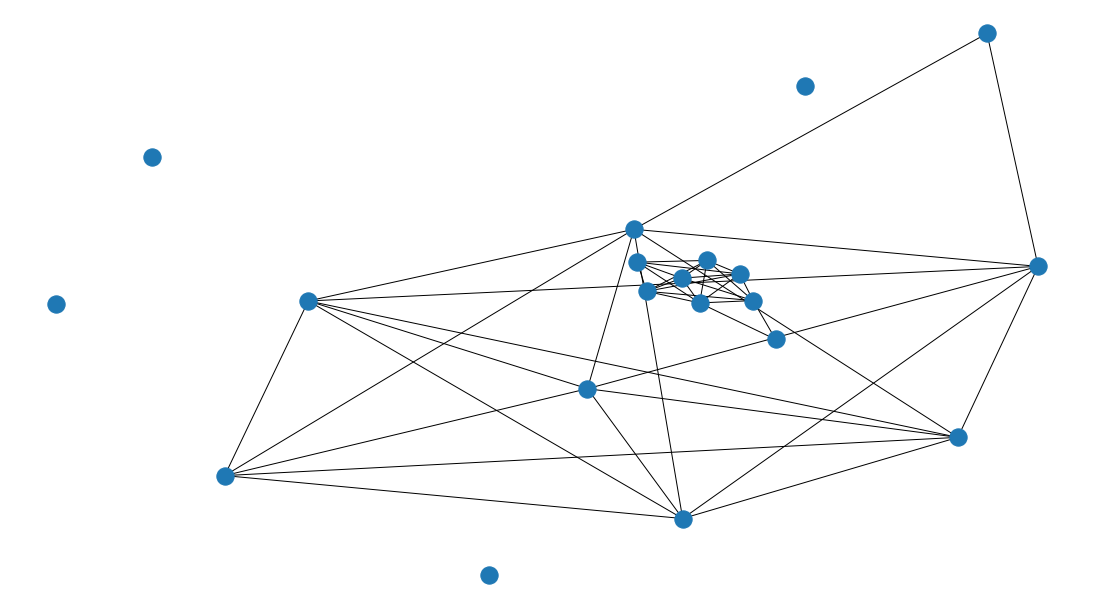

In [70]:
graph = loader_test.dataset[8]

G = to_networkx(graph, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)

plt.show()

#### Modified methods

In [15]:
def load_dataset(
    connectivity: str = 'wasserstein', batch_size: int = 8,
    test_size: float = 0.2, val_size: float = 0.1, seed: int = 27,
    verbose: int = 0
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Get training, validation, and testing DataLoaders.
    Mainly used as a high-level data fetcher in the running script.

    Args:
        connectivity (str, optional): node connectivity method.. Defaults to 'wasserstein'.
        batch_size (int, optional): [description]. Defaults to 8.
        test_size (float, optional): Ratio of test set. Defaults to 0.2.
        val_size (float, optional): Ratio of validation set. Defaults to 0.1.
        seed (int, optional): Random seed. Defaults to 27.
        verbose (int, optional): tuneable parameter for output verbosity. Defaults to 1.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]:
            * loader_train (DataLoader): packaged training dataset.
            * loader_val (DataLoader): packaged validation dataset.
            * loader_test (DataLoader): packaged testing dataset.
    """

    labels, lesions, patients = fetch_data(verbose)
    
    X_train, X_val, X_test, y_train, y_val, y_test = \
        preprocess(labels, lesions, patients,
                   test_size=test_size, val_size=val_size, seed=seed,
                   verbose=verbose)
        
    loader_train = create_dataset(X=X_train, Y=y_train,
                                  batch_size=batch_size,
                                  connectivity=connectivity, verbose=verbose)
    loader_val = create_dataset(X=X_val, Y=y_val,
                                batch_size=batch_size,
                                connectivity=connectivity, verbose=verbose)
    
    # In the test loader we set the batch size to be
    # equal to the size of the whole test set
    loader_test = create_dataset(X=X_test, Y=y_test,
                                 batch_size=len(y_test), shuffle=False,
                                 connectivity=connectivity, verbose=verbose)
    
    if verbose > 0:
        print('Final amount of datapoints \n' \
              + f'  Train: {len(loader_train.dataset)} \n' \
              + f'  Validation: {len(loader_val.dataset)} \n' \
              + f'  Test: {len(loader_test.dataset)}')

    return loader_train, loader_val, loader_test

In [ ]:
def create_dataset(
    X: pd.DataFrame, Y: pd.Series, batch_size: int = 8, shuffle: bool = True,
    connectivity: str = 'wasserstein', distance: float = 0.5, verbose: int = 0
) -> DataLoader:
    """Packages preprocessed data and its labels into a `torch.utils.data.DataLoader`

    Args:
        X (pd.DataFrame): `gpcr_id` indexed datapoints (lesions)
        Y (pd.Series): `gpcr_id` indexed labels. 1 is NPD.
        batch_size (int, optional): DataLoader batch size. Defaults to 8.
        shuffle (bool, optional): shuffle graphs in DataLoader. Defaults to True.
        connectivity (str, optional): node connectivity method. Defaults to 'wasserstein'.
        distance (float, optional): if `wasserstein` connectivity is chosen,
            the threshold distance in order to create an edge between nodes. Defaults to 0.5.
        verbose (int, optional): tuneable parameter for output verbosity.. Defaults to 0.

    Raises:
        ValueError: acceptable values for connectivity are: 'fully', 'organ', and 'wasserstein'

    Returns:
        DataLoader: packaged dataset within a DataLoader instance.
    """
    
    lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
    # Filter out benign lesions and non-post-1 studies
    lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')]
    
    max_num_nodes = lesions.groupby('gpcr_id').size().max()
    
    dataset = []
    skipped = 0
    
    to_dense = ToDense(num_nodes=max_num_nodes)

    for patient in list(X.index.unique()):

        # Create patient sub-DataFrame of all his post-1 study lesions
        pdf = lesions[lesions.gpcr_id == patient].reset_index()
        
        # Sanity check
        assert pdf.shape[0] == X[X.index == patient].shape[0], f'Unequal lesion count for patient {patient}'
        
        num_nodes = pdf.shape[0]
        edge_index = []
        
        # Skip single-noded graphs
        if num_nodes < 2:
            skipped += 1
            continue

        # Connect lesions using different methodologies
        if connectivity == 'organ':
            # Connect all lesions that are assigned to the same organ
            for i in range(num_nodes):
                source = pdf.loc[i].assigned_organ
                targets = list(pdf[pdf.assigned_organ == source].index)

                edge_index.extend([[i, j] for j in targets if i != j])
                
        elif connectivity == 'fully':
            # Create a fully-connected network representation
            edge_index = list(permutations(range(num_nodes), 2, ))
            
        elif connectivity == 'wasserstein':
            # Use the mean and std of the SUV of each lesion to simulate SUV distributions (normal)
            # and subsequently connect nodes with similar SUV distributions using the Wasserstein distance
            # as a distance metric
            for i in range(num_nodes):
                source_mean, source_sd = pdf.loc[i].mean_suv_val, pdf.loc[i].sd_suv_val
                source_distribution = np.random.normal(source_mean, source_sd, 1000)
                
                targets = [id for id, mu, sd in zip(pdf.index, pdf.mean_suv_val, pdf.sd_suv_val)
                           if wasserstein_distance(source_distribution,
                                                   np.random.normal(mu, sd, 1000)) < distance]

                edge_index.extend([[i, j] for j in targets])
            
        else:
            raise ValueError(f'Connectivity value not accepted: {connectivity}.'
                             "Must be either 'fully', 'wasserstein', or 'organ'.")

        edge_index = torch.tensor(edge_index).t().long()
    
        x = torch.tensor(X.loc[patient].reset_index(drop=True).to_numpy().astype(np.float32))
        y = torch.tensor(Y.loc[patient])

        dataset.append(to_dense(
            Data(x=x, edge_index=edge_index, num_nodes=num_nodes, y=y.reshape(-1))))
        
    if verbose > 0:
        print(f'Skipped {skipped} graphs as they have less than 2 nodes.')
        
    return DenseDataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

#### Testing the difference between GraphConv and DenseGraphConv

In [ ]:
example = loader_train.dataset[0]

In [ ]:
example

In [19]:
channels = 37
sparse_conv = GraphConv(channels, channels)
dense_conv = DenseGraphConv(channels, channels)

In [20]:
# Verify that initial weights are the same
for p1, p2 in zip(dense_conv.parameters(), sparse_conv.parameters()):
    p1 = p2

In [21]:
sparse_out = sparse_conv(example.x, example.edge_index)
assert sparse_out.size() == (example.num_nodes, channels)

ValueError: `MessagePassing.propagate` only supports `torch.LongTensor` of shape `[2, num_messages]` or `torch_sparse.SparseTensor` for argument `edge_index`.

In [ ]:
ToDense()(example)

In [ ]:
example

In [ ]:
dense_out = dense_conv(example.x, example.adj, example.mask)[0]

assert dense_out.size() == (example.num_nodes, channels)

assert torch.allclose(sparse_out, dense_out, atol=1e-04)

In [ ]:
sns.heatmap(sparse_out.detach().numpy())

In [ ]:
sns.heatmap(dense_out.detach().numpy())

### Testing DiffPool

In [ ]:
class DiffPool(torch.nn.Module):
    def __init__(self,
        num_classes: int,
        hidden_dim: int,
        node_features_dim: int,
    ):
        super(DiffPool, self).__init__()

        num_nodes_1 = 50
        
        self.gnn1_pool = GNN(node_features_dim, hidden_dim, num_nodes_1)
        self.gnn1_embed = GNN(node_features_dim, hidden_dim, hidden_dim)
        
        num_nodes_2 = 5
        
        self.gnn2_pool = GNN(hidden_dim, hidden_dim, num_nodes_2)
        self.gnn2_embed = GNN(hidden_dim, hidden_dim, hidden_dim)
        
        self.gnn3_embed = GNN(hidden_dim, hidden_dim, hidden_dim)
        
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, x, adj, mask=None):
        
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)
        
        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)
        
        x = self.gnn3_embed(x, adj)
        
        x = x.mean(dim=1)
        
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2

In [ ]:
model = DiffPool(num_classes=2, hidden_dim=32, node_features_dim=37)

In [ ]:
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
        
    return correct / len(loader.dataset)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.001)

for epoch in tqdm(range(100)):

    model.train()

    loss_a = 0.

    for batch in loader_train:

        optimizer.zero_grad()
        
        output, _, _ = model(batch.x, batch.adj, batch.mask)
        
        loss = F.nll_loss(output, batch.y.view(-1))
        loss.backward()
        loss_a += batch.y.size(0) * loss.item()
        
        optimizer.step()
    
    if epoch % 15 == 0:
        
        print(f'Epoch: {epoch:03d}, Train loss: {loss_a / len(loader_train.dataset):.4f}')

        tra_acc = test(loader_train)
        val_acc = test(loader_val)

        print(f'Training acc: {tra_acc:.4f}, Validation acc: {val_acc:.4f}')
                       
tes_acc = test(loader_test)
print(f'Testing acc: {tes_acc:.4f}')